# Machine Learning met Python

In dit onderdeel kijken we naar een fractie van de mogelijkheden die Python biedt voor machine learning. De Open Source Software community heeft een grote rol gespeeld in het neerzetten van een interface, bovenop numpy en scipy, met een hoop eenheid en gebruiksgemak. Let wel, vanwege het open source karakter is het nog wel eens aan verandering onderhevig. Over het algmeen worden deze veranderingen aangekondigd met warnings ruim voordat de oude code niet meer werkt, maar houd er rekening mee dat als je meer dan een jaar niet met software hebt gewerkt en de packages ververst, dat code dan wellicht niet meer helemaal werkt.

We zullen kijken naar supervised en unsupervised learning technieken met scikit-learn. Daarna kijken we naar de mogelijkheden van Tensorflow (met Keras frontend) voor (diepe) neurale netwerken.

scikitlearn (te importeren als sklearn) bevat allerlei functionaliteiten in allerlei packages. Bijvoorbeeld:
- datasets: het verkrijgen van data
- linear_models: bevat lineaire modellen
- neighbors: nearest neighbor modellen
- svm: Support Vector Machines
- model_selection: functionaliteit om modellen te beoordelen
- tree: beslisbomen etc.
- preprocessing: voorbereiden van data

In [1]:
# ALgemene imports. Imports die specifiek horen bij de voorbeelden worden ter plekke ingeladen, voor de duidelijkheid van het voorbeeld.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

sns.set_style('white')
sns.set_context('poster')

## Supervised machine learning

Supervised learning is het trainen van een algoritme om een *bekend antwoord* te reproduceren en komt voornamelijk in 2 smaken:
- Classificatie: het voorspellen van labels, op basis van andere data features.
- Regressie: het voorspellen van een getalswaarde voor een grootheid op basis van andere data features.

### Logistische regressie als voorbeeld

Hier zullen we kijke naar een uitgewerkt voorbeeld van de logistische regressie. We houden het bij een simpel voorbeeld dat we makkelijk kunnen visualiseren. In de package "sklearn.datasets" zit "makeblobs" waarbij je blobs van data maakt die bij elkaar horen en een label krijgen. Logistische regressie is een lineair model voor classificatie van die labels en zit dus in "sklearn.linear_model".

X, aantal samples en aantal features: (100, 2)
y aantal samples: (100,)

Eerste 5 samples:
 [[ 4.21850347  2.23419161]
 [ 0.90779887  0.45984362]
 [-0.27652528  5.08127768]
 [ 0.08848433  2.32299086]
 [ 3.24329731  1.21460627]]

Eerste 5 labels: [1 1 0 0 1] 

De twee blobs, kleur correspondeert met het label:


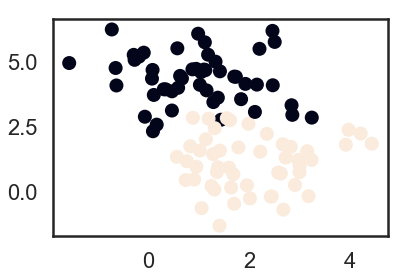

In [2]:
from sklearn.datasets import make_blobs

# Maak twee blobs. X krijgt 2D coordinaten en y is een label voor bij welke blob de data hoort.
X, y = make_blobs(centers=2, random_state=0)

print('X, aantal samples en aantal features:', X.shape)
print('y aantal samples:', y.shape)

print('\nEerste 5 samples:\n', X[:5, :])
print('\nEerste 5 labels:', y[:5], '\n')

# En in een simpel plaatje
plt.scatter(X[:,0], X[:,1], c=y);
print("De twee blobs, kleur correspondeert met het label:")

Omdat het wel blijkt dat alleen de y-variabele in dat plaatje echt belangrijk is, kijken we eerst naar een voorbeeld waarin we alleen het label proberen te voorspellen als functie van y:

In [3]:
x  =  np.reshape(X[:,1], (-1, 1))          # Die truc met reshape is nodig omdat de regresse een tweedimensionale data container verwacht. Zie de -1!
print(np.shape(x))
print(np.shape(y))

(100, 1)
(100,)


In [4]:
# Laadt en initialiseer de lineaire regressie
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

Op dit moment bestaat er een instantie van een logistisch regressie-object. Deze heeft nog niks gedaan, maar er zijn wel een hoop dingen die nu gedaan kunnen worden. In de eerste plaats kun je een model fitten, met de "fit()" methode. Nadat dat gedaan is kun je het model ook evalueren. "score()" is de methode die je daarvoor gebruikt en in het geval van een logistische regressie krijg je dan de fractie van labels die je goed hebt voorspeld. Met "predict(x)" kun je voorspellingen van je model voor (nieuwe) datapunten berekenen.

In [5]:
classifier.fit(x, y)
voorspelling_van_het_model = classifier.predict(x)
classifier.score(x,y)  # R**2

0.94

Je kunt ook de logistische functies die je daadwerkelijk hebt gefit bekijken. Voor elk punt krijg je een probability dat het datapunt een bepaald label heeft. Deze krijg je door de methode "predict_proba()" aan te roepen op een array getallen. Als je twee mogelijke labels had resulteert dat dus in een array met net zoveel rijen als je inputvector en twee kolommen (waarvan de waarden optellen tot 1):

(100, 2)


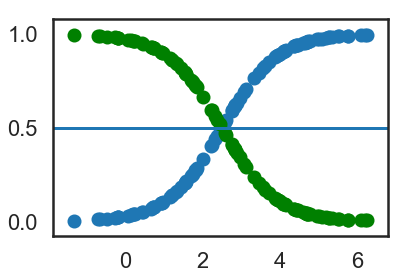

In [6]:
# De waarschijnlijkheden van de beide labels (tellen uiteraard beide op tot 1)
print(np.shape(classifier.predict_proba(x)))
plt.scatter(x, classifier.predict_proba(x)[:,0])
plt.scatter(x, classifier.predict_proba(x)[:,1], c='green')
plt.axhline(y=0.5);

De logistische regressie, zoals vele andere modellen, kan een willekeurig aantal dimensies aan in je inputdata, en kan ook meer dan twee labels voorspellen. HIer zie je het voorbeeld uitgewerkt voor de oorspronkelijke dataset met twee dimensies in de inputarray, en nog steeds twee mogelijke labels.

0.92
(100, 2)


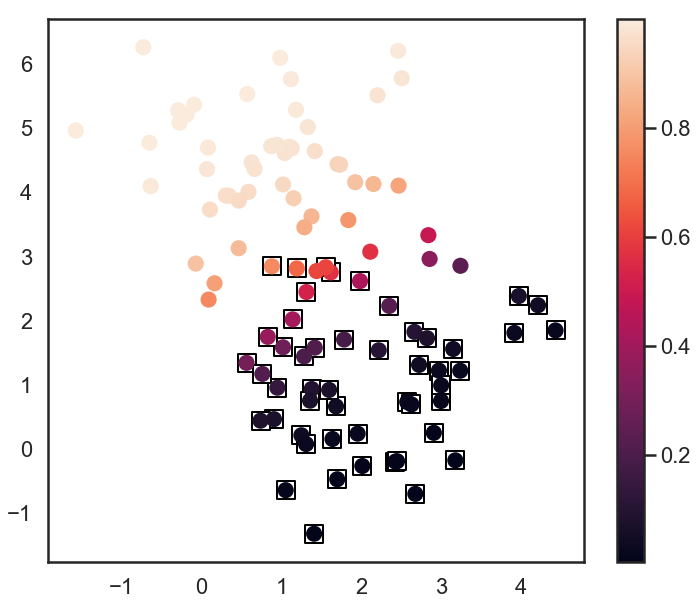

In [7]:
# Nu even op de 2D dataset. Helpt dat?
classifier.fit(X, y)
print(classifier.score(X,y))

print(np.shape(classifier.predict_proba(X)))
plt.figure(figsize=(12, 10))
plt.scatter(X[y==1,0], X[y==1,1], s=300, marker='s', c='white', edgecolors='black')
plt.scatter(X[:,0], X[:,1], c=classifier.predict_proba(X)[:,0], s=200)
plt.colorbar();

## Unsupervised machine learning
Unsupervised machine learning is een klasse van modellen die je kunt trainen, waarbij *niet* van te voren een juist antwoord bekend is. Wat valt er dan te trainen? Ook unsupervised machine learning komt in grofweg in twee varianten:
- Dimensiereductie en patroonherkenning: in datasets met zeer veel dimensies zit vaak wel het een en ander aan structuur. Deze modellen zijn ervoor om je te helpen zulke structuren te vinden, maar ook om je dataset te transformeren naar een dataset met veel minder dimensies, zonder dat je daarmee veel "inzicht" over je data verliest.
- Clustering en segmentatie: in grote datasets wil het nog wel eens gebeuren dat verschillende observaties clusteren in kliekjes. Deze klasse van modellen is ervoor om zulke kliekjes op te sporen.

### k-means clustering als een voorbeeld van unsupervised learning
Als voorbeeld kijken we naar een veelgebruikt clustering-algoritme: k-means. We maken opnieuw gebruik van make_blobs om ditmaal 3 blobs te maken, die we met behulp van k-means willen terugvinden.


(100, 2)


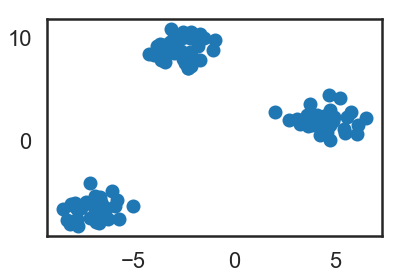

In [8]:
X, y = make_blobs(random_state=42)
print(X.shape)

plt.scatter(X[:, 0], X[:, 1]);

KMeans vinden we in sklearn.cluster en bij het maken van de instantie kun je meegeven hoeveel clusters er moeten worden gevonden. Vaak weet je dat vantevoren niet. In het geval van unsupervised learning is het veelal experimenteren tot je de juiste "hyperparameters" (de parameters die een model sturen) hebt gevonden:

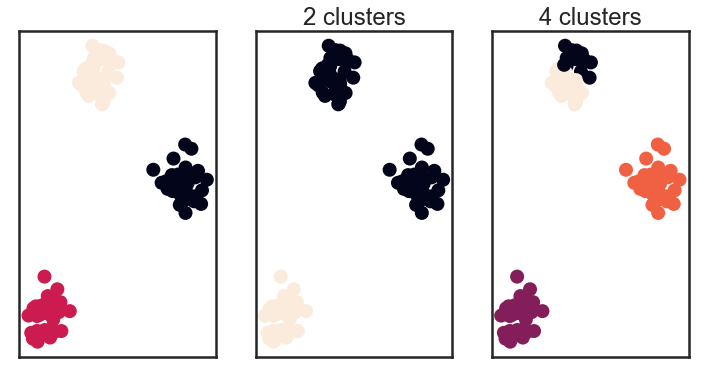

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.xticks([])
plt.yticks([]);

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=labels);
plt.title("2 clusters")
plt.xticks([])
plt.yticks([]);

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X)
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.title("4 clusters")
plt.xticks([])
plt.yticks([]);


Ook bij het voorkomen van clusters van verschillende afmetingen (of compactheid) kan KMeans in de problemen komen. Blijf experimenteren!

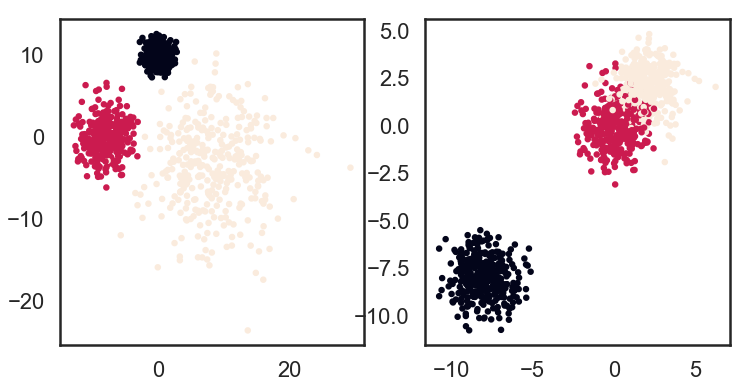

In [10]:
X1, y1 = make_blobs(random_state=101, cluster_std=[1, 2, 5], centers=[[0, 10],[-8, 0], [8,-4]], n_samples=1000, )
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=20)
X2, y2 = make_blobs(random_state=101, centers=[[-8, -8],[0, 0], [2,2]], n_samples=1000, )
plt.subplot(122)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=20);

## De MNIST hand-written digits dataset
Als voorbeeld kijken we naar de "MNIST hand-written digits" dataset, een veelgebruikte dataset voor tutorials over neurale netwerken. Deze wordt hieronder eerst gedownload (tenzij je hem op de aangegeven plek al hebt) en visueel geinspecteerd. Het bevat 70k plaatjes van 784 pixels (28x28) die een handgeschreven getal laten zien, met bijbehorend label (0-9).

In [11]:
from sklearn.datasets import fetch_mldata
# Data wordt subdirectory data opgeslagen, en gedownload als deze nog niet bestaat.
mnist = fetch_mldata("MNIST original", data_home='./data/')  

X, y = mnist.data / 255., mnist.target

print("Dimensies van X:", X.shape)
print("Dimensies van y:", y.shape)

Dimensies van X: (70000, 784)
Dimensies van y: (70000,)


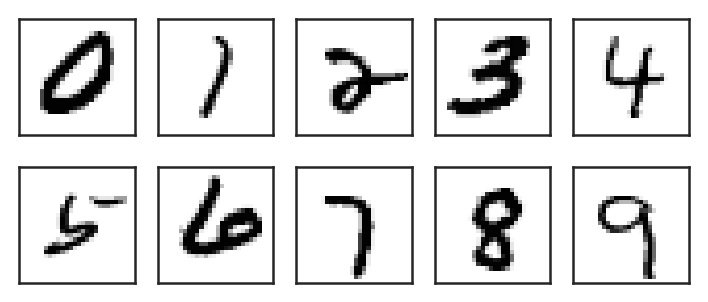

In [12]:
# Zoals je wellicht opvalt zijn er 784 pixels, eat toevallig 28**2, de "shape" van de plaatjes 
imsize = 28

# Bekijk van elk getal een random voorbeeld. Als je deze cell meerdere keren uitvoert krijg je steeds een nieuwe serie. 
plt.figure(figsize=[12, 5])
for target in range(10):
    deze = np.random.choice(np.where(y == target)[0])
    number = np.reshape(np.array(X[deze]), [imsize, imsize])
    pp = plt.subplot(2, 5, target+1)
    pp.imshow(number, cmap='Greys')
    pp.set_xticklabels([])
    pp.set_yticklabels([])

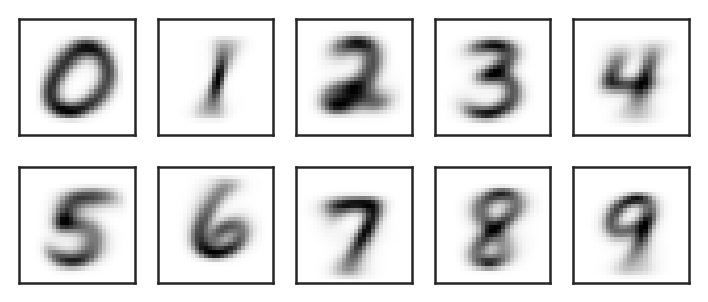

In [13]:
# We kunnen ook het "gemiddelde plaatje" van elk cijfer laten zien.
# Dit komt min of meer overeen met hetgeen we het model gaan trainen!

plt.figure(figsize=[12, 5])
for target in range(10):
    number = np.reshape( X[np.where(y==target)].mean(axis=0) , [imsize, imsize])
    pp = plt.subplot(2, 5, target+1)
    pp.imshow(number, interpolation='nearest', cmap='Greys')
    pp.set_xticklabels([])
    pp.set_yticklabels([])

### Een logistische regressie met heel veel variabelen - train_test_split()

Om te laten zien dat logistische regressie ook gewoon werkt als we 784 input features hebben en niet 2, maar 10 mogelijke labels om te voorspellen, doen we dat eerst. Daarbij introduceren we meteen een methode voor onafhankelijke evaluatie van je model: we splitsen de dataset in een *training set* (waarop het model getraind wordt) en een *test set* (die niet gebruikt wordt voor training, maar waarop je dan onafhankelijk de performance van je model kunt testen).

In [14]:
labels = y
features = X

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Het splitsen in een training en test set gebeurt hier. Check de documentatie!
xtr, x, ytr, y = train_test_split(features, labels, test_size=0.3)
clf = LogisticRegression()

In [16]:
# Performance is over het algmeen beter op de training set
clf.fit(xtr, ytr)
print(clf.score(xtr, ytr))
print(clf.score(x, y))

0.9285714285714286
0.9171904761904762


De confusion matrix is een methode om bij een model dat veel verschillende labels probeert te voorspellen na te gaan welke labels goed gaan en welke mogelijk met elkaar verward worden.

/home/marcel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


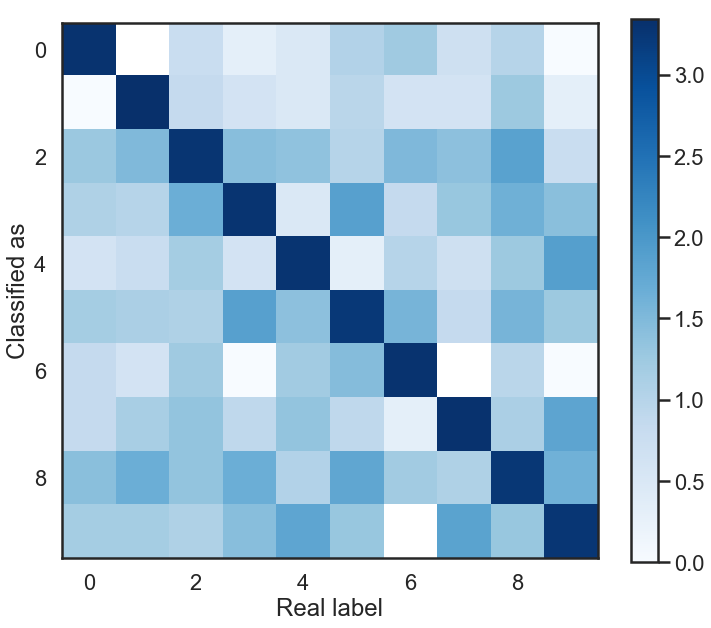

In [17]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(confusion_matrix(y, clf.predict(x))), interpolation='nearest', cmap='Blues')
plt.xlabel("Real label")
plt.ylabel("Classified as")
plt.colorbar();

## Neurale netwerken

Neurale netwerken zijn eigenlijk een soort kettingreactie van "logistische regressie"-achtige modellen via hidden layers (zie de presentatie).
Zolang we scikit-learn's Multi-layer Perceptron gebruiken kunnen we het hele netwerk in 1 keer definieren. Ook hebben we dan het voordeel dat we de volledig consistente scikit-learn interface kunnen gebruiken zoals we de gewend zijn.


In [18]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

In [19]:
mlp.fit(xtr, ytr)
mlp.score(x, y)

0.9748571428571429

In [20]:
mlp = MLPClassifier(hidden_layer_sizes=(200, 50, 50), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=50, tol=1e-4, random_state=1,
                    learning_rate_init=.1 )

mlp.fit(xtr, ytr)
mlp.score(x, y)

Iteration 1, loss = 0.37104964
Iteration 2, loss = 0.11572836
Iteration 3, loss = 0.08203315
Iteration 4, loss = 0.06211894
Iteration 5, loss = 0.04764535
Iteration 6, loss = 0.03959274
Iteration 7, loss = 0.03593660
Iteration 8, loss = 0.02681926
Iteration 9, loss = 0.02243959
Iteration 10, loss = 0.02100101
Iteration 11, loss = 0.01853503
Iteration 12, loss = 0.01756785
Iteration 13, loss = 0.01955102
Iteration 14, loss = 0.01532414
Iteration 15, loss = 0.01728493
Iteration 16, loss = 0.01428192
Iteration 17, loss = 0.00887698
Iteration 18, loss = 0.00649216
Iteration 19, loss = 0.00780610
Iteration 20, loss = 0.00760628
Iteration 21, loss = 0.01336613
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


0.9779047619047619

## Tensorflow via Keras
Tensorflow is een populair pakket voor het werken met (diepe) neurale netwerken. Tensorflow kan nog veel meer, maar hier kijken we vooral naar de Keras front-end, die uitermate geschikt is voor het werken met neurale netwerken. De definitie binnen Keras gaat per laag in het netwerk. Het geeft je meer vrijheid dan sklearn, en is dus navenant meer werk.

Binnen Keras moet je aangeven dat je een serie van lagen van neuronen gaat maken, deze vul je dan vervolgens op met lagen naar je keuze. In het voorbeeld hieronder zijn dat allemaal "dense" (ook wel "fully connected") lagen, maar dit kunnen in principe ook convolutionele lagen, pooling lagen, etc. zijn voor meer geavanceerde architecturen van je neurale netwerk.

In [21]:
import tensorflow as tf

In [22]:
# Met Sequential zet je al je lagen achter elkaar
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(200, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
# Door een model te compileren definieer je hoe het netwerk gefit moet gaan worden. 
# Dat gebeurt nog niet.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Pas met de fit() methode gebeurt het fitten, waarna het model ook geevalueerd kan worden.
model.fit(xtr, ytr, epochs=10)
print(model.evaluate(xtr, ytr))
model.evaluate(x, y)

Epoch 1/10
49000/49000 [==============================] - 24s 494us/step - loss: 0.2676 - acc: 0.9190
Epoch 2/10
49000/49000 [==============================] - 25s 514us/step - loss: 0.1056 - acc: 0.9676
Epoch 3/10
49000/49000 [==============================] - 27s 541us/step - loss: 0.0727 - acc: 0.9772
Epoch 4/10
49000/49000 [==============================] - 28s 573us/step - loss: 0.0568 - acc: 0.9816
Epoch 5/10
49000/49000 [==============================] - 28s 562us/step - loss: 0.0424 - acc: 0.9864
Epoch 6/10
49000/49000 [==============================] - 30s 613us/step - loss: 0.0372 - acc: 0.9881
Epoch 7/10
49000/49000 [==============================] - 31s 640us/step - loss: 0.0308 - acc: 0.9898
Epoch 8/10
49000/49000 [==============================] - 30s 611us/step - loss: 0.0264 - acc: 0.9917
Epoch 9/10
49000/49000 [==============================] - 30s 605us/step - loss: 0.0238 - acc: 0.9924
Epoch 10/10
49000/49000 [==============================] - 6s 125us/step
[0.008911

[0.09689563388044398, 0.9782857142857143]

Een auto-encoder reproduceert de input-laag, maar het is inzichtelijk (en potentieel heel nuttig!) om ook een netwerk met een bottleneck de labels te laten voorspellen. Hieronder proberen we dat voor een bottleneck met slechts twee neuronen.

In [23]:
nep_encoder = tf.keras.models.Sequential([
  tf.keras.layers.Dense(200, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(2, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(200, activation=tf.nn.softmax)
])
nep_encoder.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

nep_encoder.fit(xtr, ytr, epochs=10)
print("Training performance:", nep_encoder.evaluate(xtr, ytr))
print("Test performance:", nep_encoder.evaluate(x, y))

Epoch 1/10
49000/49000 [==============================] - 25s 503us/step - loss: 1.7940 - acc: 0.3416
Epoch 2/10
49000/49000 [==============================] - 26s 521us/step - loss: 0.4397 - acc: 0.8900
Epoch 3/10
49000/49000 [==============================] - 28s 574us/step - loss: 0.2661 - acc: 0.9357
Epoch 4/10
49000/49000 [==============================] - 30s 608us/step - loss: 0.2097 - acc: 0.9492
Epoch 5/10
49000/49000 [==============================] - 29s 602us/step - loss: 0.1748 - acc: 0.9581
Epoch 6/10
49000/49000 [==============================] - 30s 612us/step - loss: 0.1474 - acc: 0.9648
Epoch 7/10
49000/49000 [==============================] - 29s 585us/step - loss: 0.1277 - acc: 0.9694
Epoch 8/10
49000/49000 [==============================] - 30s 619us/step - loss: 0.1191 - acc: 0.9721
Epoch 9/10
49000/49000 [==============================] - 31s 640us/step - loss: 0.1039 - acc: 0.9760
Epoch 10/10
49000/49000 [==============================] - 6s 131us/step
Training 

In [24]:
# Een summary kan gegenereerd worden voor netwerken gemaakt met Keras:
nep_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_5 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 102       
_________________________________________________________________
dense_7 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_8 (Dense)              (None, 200)               10200     
Total params: 177,502
Trainable params: 177,502
Non-trainable params: 0
_________________________________________________________________


Ik wil hier benadrukken dat 95% van de labels correct is voorspeld, terwijl er een bottleneck-laag met slechts twee neuronen in het netwerk zit! Die laag heeft slechts 2 outputwaarden, waarna het weer opbouwende netwerk de labels bijna helemaal goed kan voorspellen. *Alle info om de labels te voorspellen ligt dus besloten in die 2 getallen!* 

Bedenk waar dat voor gebruikt kan worden. Door de plaatjes te encoden met de eerste helft van het netwerk (t/m bottleneck) kun je de plaatjes reduceren tot twee getallen. Door het tweede deel van het newterk, de decoder, te gebruiken op deze twee getallen kun je de labels behoorlijk goed reproduceren. 

Aangezien de bottleneck-laag tweedimensionaal is, kun je deze ook goed visualiseren. Het zou hierin evident moeten zijn dat er tien verschillende labels zijn. Er wordt gebruik gemaakt van de backend van keras, die een functie kan definieren die de waarden van verschillende layers in je netwerk naar elkaar mapt (feitelijk maak je hier dus de encoder).

In [25]:
from tensorflow.keras import backend as K

# Laat de functie mappen van de input naar de output van de bottleneck-laag
get_middle_layer_output = K.function([nep_encoder.layers[0].input],
                                  [nep_encoder.layers[2].output])

layer_output = get_middle_layer_output([xtr])[0]

layer_output.shape

(49000, 2)

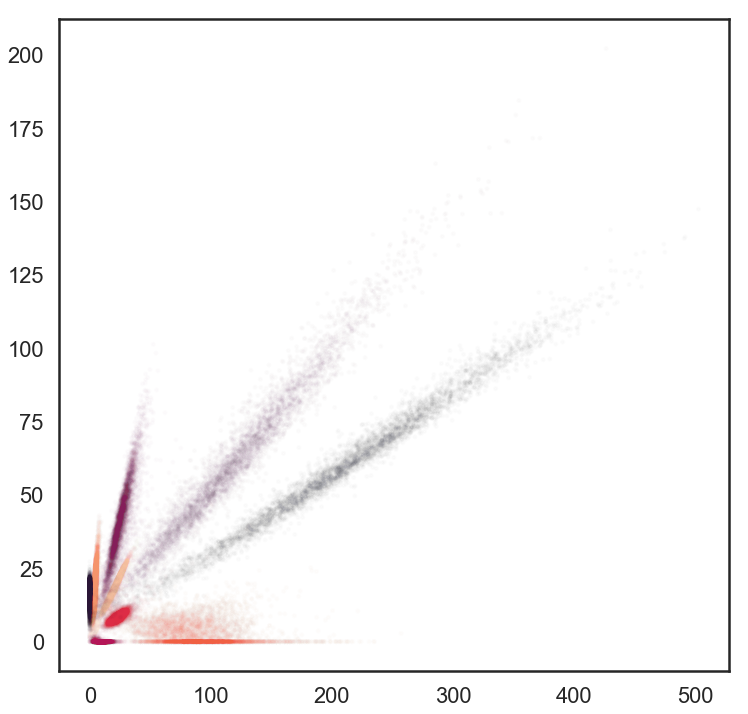

In [26]:
plt.figure(figsize=[12, 12])
plt.scatter(layer_output[:,0], layer_output[:,1], s=10, alpha=0.01, c=ytr)

Voor een daadwerkelijke auto-encoder willen we de input array reproduceren. Hierin zit dus alle informatie voor het reproduceren van het plaatje verstopt in de bottleneck-laag. Het is bijna niet voor te stellen dat een heel plaatje te reproduceren is met slechts twee getallen, maar we proberen het toch.

In [27]:
real_encoder = tf.keras.models.Sequential([
  tf.keras.layers.Dense(784, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(2, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(784, activation=tf.nn.relu)
])
real_encoder.compile(loss=tf.keras.losses.mean_squared_error,
             optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
             metrics = ['accuracy'])

real_encoder.fit(xtr, xtr, epochs=10, batch_size=256)
print("Training performance:", real_encoder.evaluate(xtr, xtr))
# print("Test performance:", real_encoder.evaluate(x, y))

Epoch 1/10
49000/49000 [==============================] - 14s 280us/step - loss: 0.0862 - acc: 0.0051
Epoch 2/10
49000/49000 [==============================] - 13s 266us/step - loss: 0.0759 - acc: 0.0145
Epoch 3/10
49000/49000 [==============================] - 14s 282us/step - loss: 0.0743 - acc: 0.0164
Epoch 4/10
49000/49000 [==============================] - 13s 272us/step - loss: 0.0736 - acc: 0.0172
Epoch 5/10
49000/49000 [==============================] - 14s 284us/step - loss: 0.0732 - acc: 0.0171
Epoch 6/10
49000/49000 [==============================] - 14s 281us/step - loss: 0.0729 - acc: 0.0174
Epoch 7/10
49000/49000 [==============================] - 14s 287us/step - loss: 0.0724 - acc: 0.0174
Epoch 8/10
49000/49000 [==============================] - 14s 293us/step - loss: 0.0719 - acc: 0.0177
Epoch 9/10
49000/49000 [==============================] - 15s 296us/step - loss: 0.0716 - acc: 0.0178
Epoch 10/10
49000/49000 [==============================] - 17s 341us/step
Training

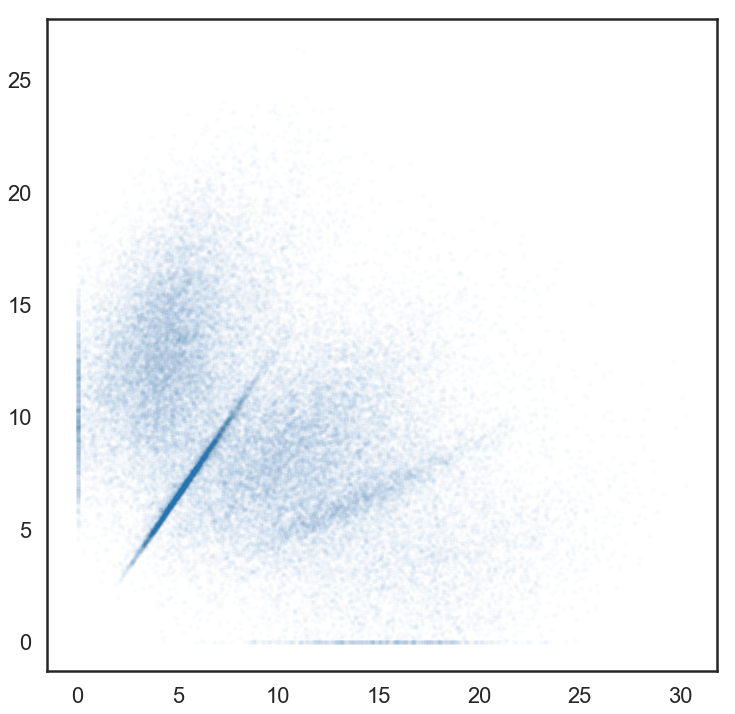

In [28]:
get_middle_layer_output = K.function([real_encoder.layers[0].input],
                                  [real_encoder.layers[2].output])
layer_output = get_middle_layer_output([xtr])[0]
plt.figure(figsize=[12, 12])
plt.scatter(layer_output[:,0], layer_output[:,1], s=10, alpha=0.01);

Zoals wellicht verwacht wanneer er niet wordt getraind op de labels, is het veel moeilijker de verschillend gelabelde plaatjes te onderscheiden in de bottleneck-laag. De performance van het model lijkt ook heel laag. Dit is echter niet zo'n betekenisvol getal: het is een maat voor hoe goed afzonderlijke pixels worden gereconstrueerd, en voor het eventueel kunnen herkennen van een plaatje kunnne die nog behoorlijk anders zijn, zoals we hieronder zullen zien.

Een realistischere auto-encoder heeft een bottle-neck laag die een stuk groter is dan 2 neuronen. Laten we er voor het voorbeeld een van 128 neuronen maken (nog altijd een factor >6 kleinere hoeveelheid data dan alle pixels!) en kijken of we de plaatjes kunnen reproduceren.

In [29]:
big_encoder = tf.keras.models.Sequential([
  tf.keras.layers.Dense(784, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(784, activation=tf.nn.relu)
])
big_encoder.compile(loss=tf.keras.losses.mean_squared_error,
             optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
             metrics = ['accuracy'])

big_encoder.fit(xtr, xtr, epochs=10, batch_size=256)
print("Training performance:", big_encoder.evaluate(xtr, xtr))
# print("Test performance:", real_encoder.evaluate(x, y))

Epoch 1/10
49000/49000 [==============================] - 17s 339us/step - loss: 0.0599 - acc: 0.0077
Epoch 2/10
49000/49000 [==============================] - 17s 343us/step - loss: 0.0387 - acc: 0.0098
Epoch 3/10
49000/49000 [==============================] - 17s 345us/step - loss: 0.0333 - acc: 0.0095
Epoch 4/10
49000/49000 [==============================] - 17s 353us/step - loss: 0.0305 - acc: 0.0106
Epoch 5/10
49000/49000 [==============================] - 17s 357us/step - loss: 0.0286 - acc: 0.0103
Epoch 6/10
49000/49000 [==============================] - 17s 353us/step - loss: 0.0272 - acc: 0.0111
Epoch 7/10
49000/49000 [==============================] - 17s 348us/step - loss: 0.0261 - acc: 0.0118
Epoch 8/10
49000/49000 [==============================] - 19s 380us/step - loss: 0.0251 - acc: 0.0123
Epoch 9/10
49000/49000 [==============================] - 20s 399us/step - loss: 0.0243 - acc: 0.0119
Epoch 10/10
49000/49000 [==============================] - 19s 388us/step
Training

In [30]:
# Met de gebruikelijke predict() methode kunnen we de gereconstrueerde plaatjes berekenen.
reconstructed = big_encoder.predict(xtr)

Text(0.5,1,'Oorspronkelijke digit')

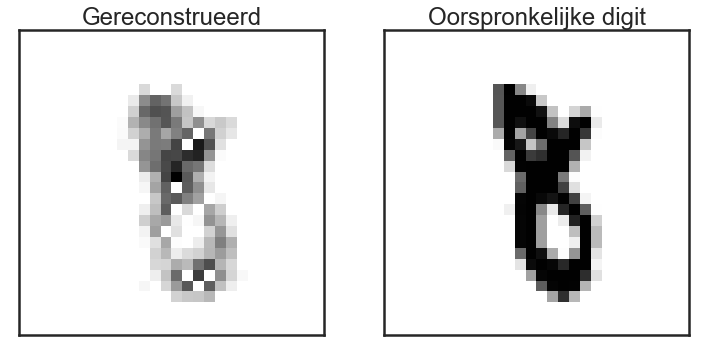

In [31]:
# Deze cell genereert een random paar oorspronkelijke-gereconstrueerde plaatjes.
# Voer hem een paar keer uit voor meerdere voorbeelden!
imsize = 28
aantal_im = len(xtr)
deze = np.random.randint(0, aantal_im)

plt.figure(figsize=(12, 24))
pp = plt.subplot(121)
number = np.reshape(reconstructed[deze], [imsize, imsize])
pp.imshow(number, cmap='Greys')
pp.set_xticklabels([])
pp.set_yticklabels([])
pp.set_title("Gereconstrueerd")

pp = plt.subplot(122)
number = np.reshape(xtr[deze], [imsize, imsize])
pp.imshow(number, cmap='Greys')
pp.set_xticklabels([])
pp.set_yticklabels([])
pp.set_title("Oorspronkelijke digit")


Gewoon omdat het kan kijken we ook nog even naar de gereconstrueerde plaatjes van de auto-encoder met slechts 2 neuronen in de bottleneck. Werkt soms nog best heel aardig!

Waar dergelijke exercities nuttig voor kunnen zijn:
- Na het trainen op "clean" images, worden plaatjes met veel ruis ook netjes gereconstrueerd (de-noising auto-encoder).
- Compressie van data.
- Snelle evaluatie van resultaten met de "functions"

In [32]:
real_constructed = real_encoder.predict(xtr)

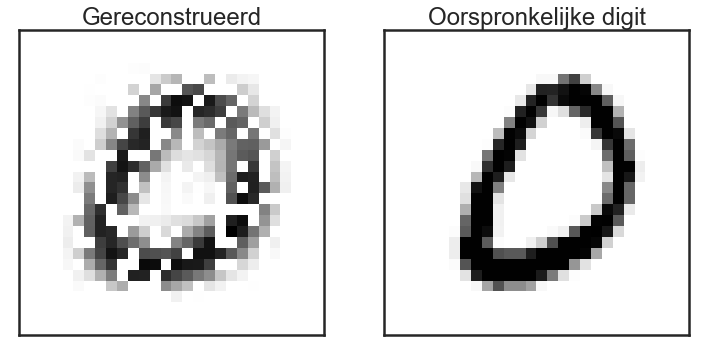

In [46]:
imsize = 28
aantal_im = len(xtr)
deze = np.random.randint(0, aantal_im)

plt.figure(figsize=(12, 24))
pp = plt.subplot(121)
number = np.reshape(real_constructed[deze], [imsize, imsize])
pp.imshow(number, cmap='Greys')
pp.set_xticklabels([])
pp.set_yticklabels([])
pp.set_title("Gereconstrueerd")

pp = plt.subplot(122)
number = np.reshape(xtr[deze], [imsize, imsize])
pp.imshow(number, cmap='Greys')
pp.set_xticklabels([])
pp.set_yticklabels([])
pp.set_title("Oorspronkelijke digit");

## Referenties

Python Data Science Handbook (en al het andere youtube- en blogmateriaal van auteur Jake VanderPlas, zie http://jakevdp.github.io/), geheel in notebooks op github: https://jakevdp.github.io/PythonDataScienceHandbook/

Antwoorden op al je vragen (of ze staan er al, of je hebt ze snel) op StackOverflow: https://stackoverflow.com/

Documentatie van de voor data science belangrijke paketten: https://docs.scipy.org/doc/, http://pandas.pydata.org/pandas-docs/stable/

Voor visualisatie gebruiken we matplotlib (https://matplotlib.org/ en de gallery op https://matplotlib.org/gallery/index.html), seaborn (https://seaborn.pydata.org/) en bokeh (https://bokeh.pydata.org/en/latest/).

Verder vind je op YouTube veel praatjes en workshops (vaak met materiaal op github). Let er wel op dat je redelijk recent materiaal bekijkt, sommige van deze paketten zijn nog stevig in ontwikkeling. Op YouTube kun je zoeken naar PyData, (Euro)SciPy, Pycon, Enthought en Numfocus. Dat geeft je een hele hoop materiaal.